In [981]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
import pickle
import glob
from config import configuration
config = configuration()
config.request_password()

 ·············


In [2]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    v = pickle.load(f)

Text(0, 0.5, 'phi1-2phi0')

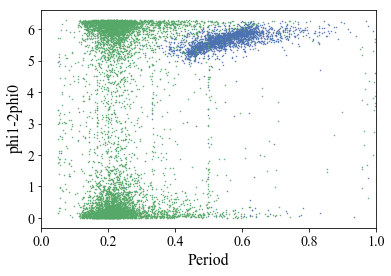

In [3]:
plt.plot(v['lsq_period'][(v['var_class']=='RRab')&(v['ks_n_detections']>500)],
         (v['phi_1']-2*v['phi_0'])[(v['var_class']=='RRab')&(v['ks_n_detections']>500)]%(2.*np.pi),'.',ms=1);

plt.plot(v['lsq_period'][(v['var_class']=='EW')&(v['ks_n_detections']>500)],
         (v['phi_1']-2*v['phi_0'])[(v['var_class']=='EW')&(v['ks_n_detections']>500)]%(2.*np.pi),'.',ms=1);

plt.xlim(0.,1.)
plt.xlabel('Period')
plt.ylabel('phi1-2phi0')

In [877]:
import sys
# sys.path.append('../../../../variability/')
# sys.path.append('../fine_classif/feat_extract/')
from fine_classif.feat_extract.compute_feats import compute_peak_properties, optimum_regularization, sigclipper, periodic_feats_force
from fine_classif.feat_extract import *
from fine_classif.feat_extract.lc_utils import *

[0.59151415] [13.9741314]
[3.20176288 0.59151415 1.45371054 2.51348335 3.10239752 1.19040235
 0.49909974 1.16683804 1.44853674 0.99651244]


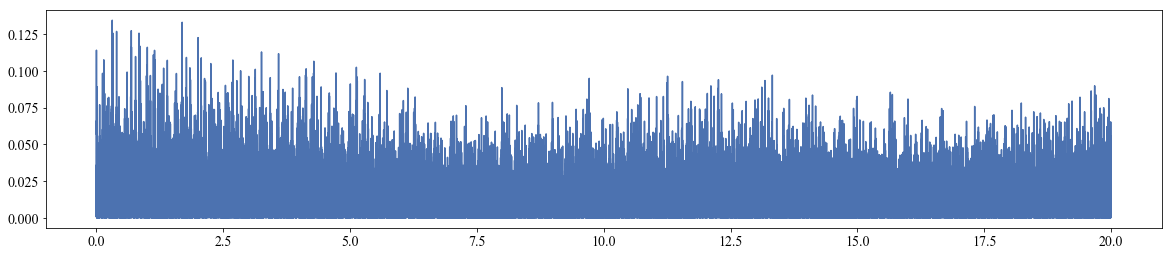

In [955]:
ii=0
typee='EA/EB'
fltr = (v['var_class']==typee)&(v['ks_n_detections']>1000)
fltr = (v['sourceid']==8700868005182)
sid,period,cat_period=v[['sourceid']][fltr].values[ii], v[['ls_period']][fltr].values[ii], v[['cat_period']][fltr].values[ii]

import sqlutilpy as sqlutil
ss_original = pd.DataFrame(sqlutil.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match,
                                unnest(chi) as chi,
                                unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
ss = ss_original.copy()
ss = ss[(ss['mag']>0.)&(ss['ast_res_chisq']<11.829)&(ss['ambiguous_match']==0)].reset_index(drop=True)
ss = sigclipper(ss,sig_thresh=5).reset_index(drop=True)
print(period,cat_period)

# from lc_utils import fourier_poly_chi2_fit_full, plot_lc_LSQ
reg = optimum_regularization(ss['mag'].values,ss['error'].values)
npoly=1
min_f = np.float64(config['ls_min_freq'])
# min_f = 1./10.
# NF=len(autofrequency(ss_original['mjdobs'].values,minimum_frequency=min_f,maximum_frequency=np.float64(config['ls_max_freq'])))
# print(NF)
lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                               {'f0':min_f,'f1':np.float64(config['ls_max_freq']),'Nf':NF},nterms=1,
                               time_zeropoint_poly=np.nanmean(ss['mjdobs'].values), regularization=0.,npoly=npoly)
LSS = lombscargle_stats(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                        maximum_frequency=np.float64(config['ls_max_freq']), minimum_frequency = min_f, N=30)
print(1./LSS['top_distinct_freqs'])
model = LombScargle(ss['mjdobs'].values,ss['mag'].values,ss['error'].values, normalization='standard')    
freq, power = model.autopower(maximum_frequency=np.float64(config['ls_max_freq']), minimum_frequency = min_f)
    
    
model2 = LombScargle(ss['mjdobs'].values,
                    np.ones(len(ss)),
                    ss['error'].values,
                    center_data=False, fit_mean=False
                    )
power2 = model2.power(freq)
# fap=false_alarm_probability(power, np.float64(config['ls_max_freq']), ss['mjdobs'].values,ss['mag'].values,ss['error'].values)
# fap2=false_alarm_probability(power2, np.float64(config['ls_max_freq']), ss['mjdobs'].values,ss['mag'].values,ss['error'].values)
# # print(1./LSS['top_distinct_freqs'])
# # print(2./LSS['top_distinct_freqs'])
# # print(lsc['lsq_period'])
# # lsc_T=fourier_poly_chi2_fit_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
# #                                             {'freq_grid':np.array([.5/lsc['lsq_period'],1./lsc['lsq_period']])},
# #                                             nterms_min=1,nterms_max=10,
# #                                             regularization=reg,
# #                                             time_zeropoint_poly=lsc['lsq_time_zeropoint_poly'],
# #                                             use_bic=False,
# #                                             npoly=lsc['lsq_npoly'])
# # print(lsc_T['lsq_period'])

# # lsc_T=fourier_poly_chi2_fit_test(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
# #                                             {'freq_grid':np.array([.5/lsc['lsq_period'],1./lsc['lsq_period']])},
# #                                             nterms_min=1,nterms_max=10,
# #                                             regularization=reg,
# #                                             time_zeropoint_poly=lsc['lsq_time_zeropoint_poly'],
# #                                             use_bic=False,
# #                                             npoly=lsc['lsq_npoly'])
# # print(lsc_T['lsq_period'])
# # print(lsc_T['lsq_nterms'])


plt.figure(figsize=[20.,4.])
plt.plot(freq,power,zorder=-3)
# plt.plot(freq,power2,zorder=-3)
# plt.xlim(cat_period*2.-0.3,cat_period*2.+0.3)
# plt.semilogy()
# plt.xlim(0.9,1.1)
# # plt.ylim(1e-20,1)
# # plt.xlim(1./0.28874227-0.2,1./0.28874227+0.2)
# plt.figure()
# plt.plot(power,fap,'.')
# plt.plot(power2,fap2,'.')
# plt.axvline(0.018)
# plt.semilogx()
# plt.figure()
# plt.semilogy()
# # plt.plot(freq,power)
# # plt.plot(freq2,power2)
# # plt.semilogy()
# # plt.xlim(2./cat_period-.01,2./cat_period+.01)
# plt.axvline(2./cat_period)
# plt.semilogx()
# # plt.semilogy()
# plt.ylim(1e-4,1.)
# plt.figure()
# # plt.plot(lsc['fre']);
# # plt.figure(LSS[''])
# plt.plot(ss['mjdobs'].values % (2. * lsc['lsq_period']), ss['mag'].values, '.');
# # plt.gca().invert_yaxis()






# print('chi2',lsc['chi2_ref'])
# plot_lc_LSQ(ss, lsc, fold=True);
# print(find_peak_ratio(ss,lsc))
# print(find_peak_ratio_model(ss,lsc))
# lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,.5/lsc['lsq_period'],2./lsc['lsq_period'],4,10,
#                               regularization=1e-4,regularize_by_trace=True)
# print('chi2',lsc['chi2_ref'])

# print(lsc['lsq_period'])
# print(lsc['amplitudes'])
# # lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,1./(lsc['lsq_period']*2.),1./(lsc['lsq_period']*2.)*1.01,10000,3)
# plot_lc_LSQ(ss, lsc, fold=True);
# ss2 = ss.copy()
# ss2['mjdobs']+=lsc['phases'][0]*lsc['lsq_period']/(2.*np.pi)
# lsc2=fourier_poly_chi2_fit_full_quick(ss2,nterms=4,minp=0.1,maxp=10.)
# plot_lc_LSQ(ss2, lsc2, fold=True);
# print(lsc['amplitudes'])
# print(lsc2['fourier_coeffs'])

In [954]:
v[['sourceid','cat_period','lsq_period']][(np.abs(v['lsq_period']-0.5)<1e-3)&(np.abs(v['cat_period']/v['lsq_period']-1)>0.1)&(np.abs(.5*v['cat_period']/v['lsq_period']-1)>0.1)]

,sourceid,cat_period,lsq_period
1527,8422358017386,0.665901,0.499796
4374,8491999026103,0.406665,0.500918
10068,8561632003366,0.666819,0.500883
13136,8594381000889,2.000109,0.500019
18380,8639442058273,18.931806,0.500034
18989,8643569000351,0.333024,0.499975
22862,8672200013207,98.610000,0.499494
27744,8700868005182,13.974131,0.499100
40467,8762312042793,1.489199,0.500188
2096,8786884005445,2.003801,0.500942


/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


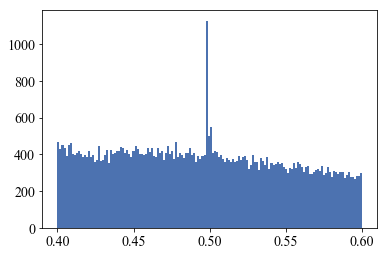

In [952]:
plt.hist(v['lsq_period'],bins=150,range=[0.4,0.6]);

In [887]:
print(fal(1e-100, np.float64(config['ls_max_freq']), ss['mjdobs'].values,ss['mag'].values,ss['error'].values, normalization='standard'))

1.0


In [895]:
stmp = ss.copy()[:100]
stmp['mjdobs']=np.linspace(0.,len(stmp)-1, len(stmp))+np.random.normal(0.,0.1,len(stmp))
LSS = lombscargle_stats(stmp['mjdobs'].values,stmp['mag'].values,stmp['error'].values,
                        maximum_frequency=np.float64(config['ls_max_freq']), minimum_frequency = min_f, N=30)

model = LombScargle(stmp['mjdobs'].values,stmp['mag'].values,stmp['error'].values, normalization='standard')    
freq, power = model.autopower(maximum_frequency=np.float64(config['ls_max_freq']), minimum_frequency = min_f)
    
    
model2 = LombScargle(stmp['mjdobs'].values,
                    np.ones(len(stmp)),
                    stmp['error'].values*0.02,
                    center_data=False, fit_mean=False
                    )
power2 = model2.power(freq)


fap=false_alarm_probability(power, np.float64(config['ls_max_freq']), stmp['mjdobs'].values,stmp['mag'].values,stmp['error'].values)
fap2=false_alarm_probability(power2, np.float64(config['ls_max_freq']), stmp['mjdobs'].values,stmp['mag'].values,stmp['error'].values)

[ 0.46537601  0.4649387   0.46581415  0.87235313  0.87081776 17.56193095
  0.46450221  0.3175355   0.31733184  1.05908327  1.06135514  0.87389392
  0.86928779  0.11570516  0.11567811 18.20822765 16.95994186  0.09657594
  0.06797136  0.0679807   0.31773941  0.05681735  0.94571992  0.38409066
  0.05682387  0.31712844  0.08806693  0.06365165  1.05682111  0.06364346]
W [0.3175355  0.31733184 0.87389392 0.11567811 0.31773941 0.05681735
 0.05682387 0.31712844 0.08806693]


(0.0, 0.13)

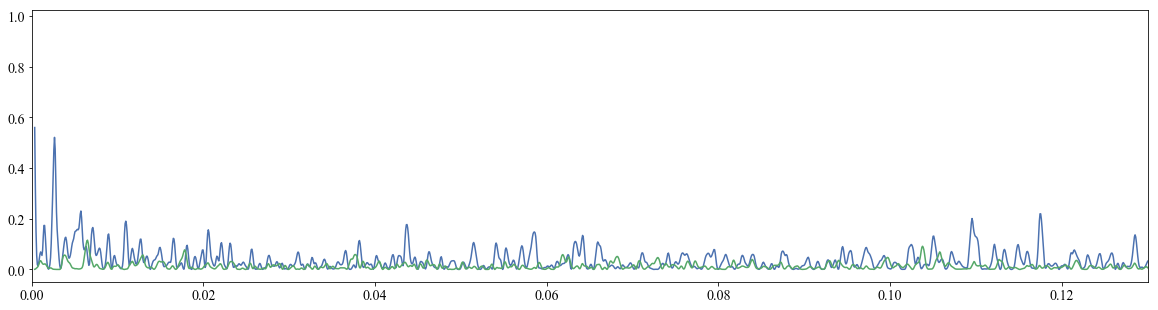

In [947]:
plt.figure(figsize=[20.,5.])
plt.plot(freq,power2)
plt.plot(freq,power)
plt.xlim(0.,0.13)
# plt.xlim(1./0.24660756-0.2,1./0.24660756+0.2)

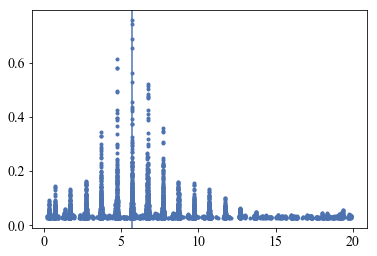

In [760]:
plt.plot(freq[np.argsort(power)][::-1][:5000],power[np.argsort(power)][::-1][:5000],'.')
# plt.xlim(5.65,5.75)
plt.axvline(1./period)

In [746]:
%timeit -n 1 -r 1 model.power(freq[np.argsort(power)][::-1][:500])

153 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [701]:
model = LombScargle(ss['mjdobs'].values,
                    np.ones_like(ss['mag'].values),
                    ss['error'].values*0.1,
                    center_data=False, fit_mean=False
                    )
freq, power = model.autopower(minimum_frequency=min_f,maximum_frequency=np.float64(config['ls_max_freq']))

model = LombScargle(ss['mjdobs'].values,
                    ss['mag'].values,
                    ss['error'].values,
                    )
freq2, power2 = model.autopower(minimum_frequency=min_f,maximum_frequency=np.float64(config['ls_max_freq']))
fap2 = false_alarm_probability(power2[:20000], np.float64(config['ls_max_freq']), ss['mjdobs'].values,
                    ss['mag'].values,
                    ss['error'].values)

(0.01, 0.1)

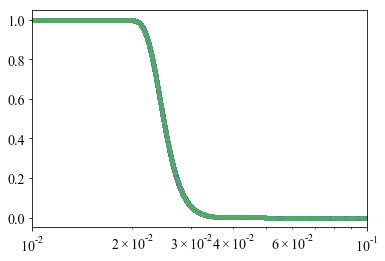

In [702]:
plt.plot(power, fap,'.')
plt.plot(power2[:20000], fap2,'.')
plt.semilogx()
plt.xlim(1e-2,1e-1)

(1.0, 3.0)

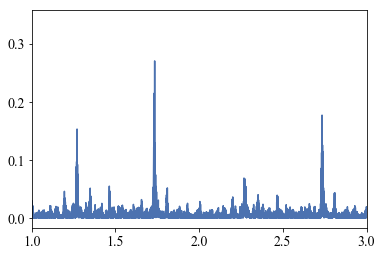

In [716]:
# plt.plot(freq, power)
plt.plot(freq2, power2);plt.xlim(1.,3.)
# plt.axvline(1.)

In [311]:
def run_looper(ss):
    return fourier_poly_chi2_fit_test(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                            {'freq_grid':np.array([.5/lsc['lsq_period'],1./lsc['lsq_period']])},
                                            nterms_min=1,nterms_max=10,
                                            regularization=lsc['lsq_regularization'],
                                            time_zeropoint_poly=lsc['lsq_time_zeropoint_poly'],
                                            use_bic=False,
                                            npoly=lsc['lsq_npoly'])
        
def run_looper_2(ss):
    return fourier_poly_chi2_fit_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                            {'freq_grid':np.array([.5/lsc['lsq_period'],1./lsc['lsq_period']])},
                                            nterms_min=1,nterms_max=10,
                                            regularization=lsc['lsq_regularization'],
                                            time_zeropoint_poly=lsc['lsq_time_zeropoint_poly'],
                                            use_bic=False,
                                            npoly=lsc['lsq_npoly'])

In [462]:
from fine_classif.feat_extract.extract_feats import source_feat_extract

In [542]:
np.float64(config['ls_max_freq']), np.float64(config['ls_min_freq'])

(20.0, 0.00035)

In [553]:
config['ls_max_freq']='10.'
config['ls_min_freq']='0.01'

In [603]:
1./np.float64(config['ls_max_freq'])

0.05

In [957]:
ss_original['ra']=0.
ss_original['dec']=0.
ss_original['emag']=ss_original['error']
source_feat_extract(ss_original, config, 
                    ls_kwargs={'maximum_frequency':np.float64(config['ls_max_freq']), 
                               'minimum_frequency':np.float64(config['ls_min_freq']), 
                               'samples_per_peak':5},
                    method_kwargs={'irreg':True})

{'amp_0': 0.05767540614802711,
 'amp_1': 0.034298944778368465,
 'amp_2': 0.01547261249025018,
 'amp_3': 0.011962311319716661,
 'amp_double_0': 0.029648628466534398,
 'amp_double_1': 0.04697434938056273,
 'amp_double_2': 0.012658621390544359,
 'amp_double_3': 0.021522956628705132,
 'amplitude': 0.35050010681152344,
 'beyondfrac': 0.2839506172839506,
 'delta_loglik': 21.8178674976744,
 'error': False,
 'kurt': 0.8232806849712238,
 'ls_period': 0.5915141532768496,
 'lsq_period': 1.1903194570101818,
 'lsq_period_error': 5.967393371862648e-05,
 'max_pow': 0.1328380237665022,
 'max_time_lag': 0.02656843358943295,
 'mean': 16.340141,
 'med_magdev': 0.0,
 'peak_ratio_data': 0.5742177,
 'peak_ratio_model': 1.0,
 'phi_0': -2.559866372011239,
 'phi_1': 0.6356363166422404,
 'phi_2': -1.639347849728638,
 'phi_3': 0.5000825874798448,
 'phi_double_0': 1.4938093473329201,
 'phi_double_1': -2.5169861913423284,
 'phi_double_2': -0.9037209259808362,
 'phi_double_3': 0.6299396139493344,
 'pow_mean_disp': 

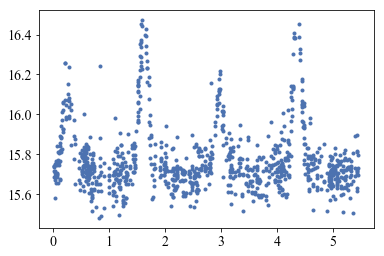

In [633]:
plt.plot(ss['mjdobs'].values % (2.*cat_period),ss['mag'].values,'.')

In [985]:
ss['ra']=0.
ss['dec']=0.
ss['emag']=ss['error']
source_feat_extract(ss, config, ls_kwargs={'maximum_frequency':np.float64(config['ls_max_freq']), 'minimum_frequency':np.float64(config['ls_min_freq'])},method_kwargs={'irreg':True})

8700868005182 feats loaded in 0.6881802082061768 s


{'amp_0': 0.05178499142767844,
 'amp_1': 0.02126486484332261,
 'amp_2': 0.00841070704565606,
 'amp_3': 0.006908249491045238,
 'amp_double_0': 0.009116484335364135,
 'amp_double_1': 0.04555356789531605,
 'amp_double_2': 0.015385882000616833,
 'amp_double_3': 0.010944766432731172,
 'amplitude': 0.3795003890991211,
 'beyondfrac': 0.24390243902439024,
 'delta_loglik': 20.889796931824378,
 'error': False,
 'kurt': 1.6292792559157467,
 'lag_time': 0.00017786026000976562,
 'log10_fap': -1.4041124765058373,
 'ls_period': 3.2017628782490912,
 'ls_time': 0.5488567352294922,
 'lsq_period': 3.2017628782490912,
 'lsq_period_error': 0.0005737589621192464,
 'lsq_power': 0.17206440791824973,
 'lsq_time': 0.0874941349029541,
 'max_pow': 0.13437558070005945,
 'max_time_lag': 0.23528042704546115,
 'mean': 16.34652,
 'med_magdev': 0.0,
 'np_time': 0.0014338493347167969,
 'peak_ratio_data': 0.89162856,
 'peak_ratio_model': 1.0,
 'phi_0': -2.7752918811764706,
 'phi_1': 1.8857441431111384,
 'phi_2': -1.43272

In [563]:
len(ss_original)

1001

In [ ]:
%timeit -n 1 -r 1 source_feat_extract(ss, config, ls_kwargs={'samples_per_peak':5,'maximum_frequency':np.float64(config['ls_max_freq']), 'minimum_frequency':1./100.},method_kwargs={'irreg':True})

In [390]:
LS=lombscargle_stats(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,maximum_frequency=np.float64(config['ls_max_freq']),
                     minimum_frequency=np.float64(config['ls_min_freq']))

In [391]:
freq_dict = dict(freq_grid=
             np.concatenate([.5*LS['top_distinct_freqs'],
                             LS['top_distinct_freqs']])) 

In [392]:
%timeit -n 1 -r 1 periodic_feats_force(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,freq_dict,npoly=3, nterms=4,nterms_max=10,fn=fourier_poly_chi2_fit_nterms_iterations)

542 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [393]:
%timeit -n 1 -r 1 periodic_feats_force(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,freq_dict,npoly=3, nterms=4,nterms_max=10,fn=fourier_poly_chi2_fit_test)


213 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [395]:
print(periodic_feats_force(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,freq_dict,npoly=3, nterms=4,nterms_max=10,fn=fourier_poly_chi2_fit_test))
print(periodic_feats_force(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,freq_dict,npoly=3, nterms=4,nterms_max=10,fn=fourier_poly_chi2_fit_nterms_iterations))

{'peak_ratio_model': 1.0, 'lsq_period': 2.7331063681774164, 'phi_double_2': -2.552356577610859, 'amp_double_1': 0.017710180007369444, 'phi_0': -1.5872364536963153, 'phi_3': 0.35605092012231704, 'amp_double_2': 0.007372826134721472, 'amp_1': 0.1423272029178034, 'delta_loglik': 1015.0918399946596, 'phi_1': -2.970976092323649, 'amp_0': 0.026558938710079912, 'phi_double_3': -2.953957096004408, 'phi_2': 1.9477859224706568, 'amp_double_0': 0.007048564513749359, 'phi_double_0': 2.502341808519732, 'amp_double_3': 0.12970366951452736, 'phi_double_1': -1.415965948765754, 'amp_3': 0.07513903139714798, 'peak_ratio_data': 0.8429184, 'lsq_period_error': nan, 'significant_second_minimum': False, 'amp_2': 0.02211158633383472}


## To do

1. Make the period multiple checks more robust -- perhaps write a new function
3. Lower the regularization used in the period finding
4. How do we get the plot in Jayasinghe??

2300
0.9998643461816605
0.19019999929238993
True


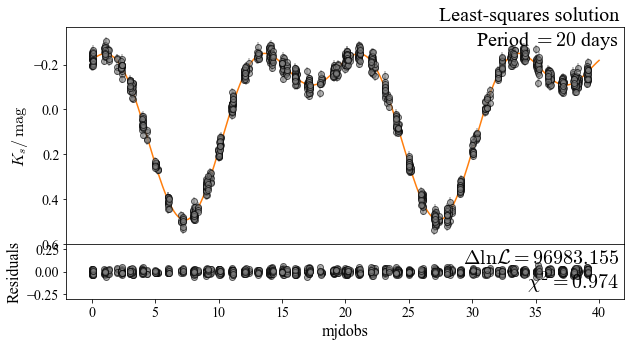

In [40]:
fake = ss.copy()
np.random.seed(42)
# fake = fake[:8].reset_index(drop=True)
fake['mjdobs']+=9.
fake['error']=0.02
fake['mag'] = 0.19*np.cos(2.*np.pi*(fake['mjdobs']-fake['mjdobs'][0])/10.)+\
                0.3*np.cos(2.*np.pi*(fake['mjdobs']-fake['mjdobs'][0])/20.)+\
                0.*np.cos(2.*np.pi*(fake['mjdobs']-fake['mjdobs'][0])/5.)+\
                np.random.normal(0., fake['error'], len(fake['error']))+\
                1e-17*(fake['mjdobs']-fake['mjdobs'][0])**2
MINP = 5.
MAXP = 20.
from lc_utils import autofrequency
NGRID = len(
            autofrequency(fake['mjdobs'].values,
                          maximum_frequency=1. / MINP,
                          minimum_frequency=1. / MAXP)) // 2 * 2
print(NGRID)
lsc_test=fourier_poly_chi2_fit_full_nterms_iterations(fake['mjdobs'].values,
                                                      fake['mag'].values,
                                                      fake['error'].values,1./MAXP,1./MINP,NGRID,
                                                      1,4,regularization=1e-4,
                                                      npoly=3, 
                                                      time_zeropoint_poly=fake['mjdobs'][0])
times = np.linspace(0.,lsc_test['lsq_period'],100)
ffp = retrieve_fourier_poly(times,lsc_test,with_var=True)
# print(lsc_test['fourier_coeffs_cov'])
plot_lc_LSQ(fake, lsc_test, fold=True);
# plt.figure()
# print(lsc_test['amplitudes'])
# from lc_utils import find_peak_ratio
# plt.plot(((fake['mjdobs']-7.187187187187187) / ( lsc_test['lsq_period'] ))% 1, 
#          fake['mag'], '.')
# plt.gca().invert_yaxis()
print(find_peak_ratio(fake, lsc_test))
print(find_peak_ratio_model(fake, lsc_test))
print(check_significant_second_minimum(fake, lsc_test))

In [176]:
print(check_significant_second_minimum(fake, lsc_test,[0.2,0.8]))

True


In [1438]:
from lc_utils import find_peak_ratio_model, string_length_grid
import time

In [1440]:
# %%timeit -n 1 -r 1
SS = string_length_grid(ss['mjdobs'].values, ss['mag'].values, 0.1,10.,50000)
print(SS[0][np.argmin(SS[1])])

6.104860064642086


In [2249]:
from lc_utils import check_second_maximum
import sys
sys.path.append('../../../../variability/')
from lc_utils import fourier_poly_chi2_fit_full_nterms_iterations, plot_lc_LSQ, fourier_poly_chi2_fit_transpose

In [2255]:
det_range=[100,1000]
typee='EA/EB'
fltr = (v['ks_n_detections']>det_range[0])&(v['ks_n_detections']<det_range[1])
sid,period,cat_period=v[['sourceid']][(v['var_class']==typee)&fltr].values[ii],\
            v[['ls_period']][(v['var_class']==typee)&fltr].values[ii],\
            v[['cat_period']][(v['var_class']==typee)&fltr].values[ii]
ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(ast_res_chisq) as arc,
                                unnest(ambiguous_match) as amb,
                                unnest(chi) as chi,
                                unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
ss = ss[(ss['mag']>0.)&(ss['arc']<11.829)&(ss['amb']==0)].reset_index(drop=True)
ss = sigclipper(ss,thresh=10).reset_index(drop=True)

%timeit -n 1 -r 1 fourier_poly_chi2_fit(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,10.,2101,regularization=0.)

model = LombScargle(ss['mjdobs'].values,ss['mag'].values,ss['error'].values, normalization='standard')
        
%timeit -n 1 -r 1 freq, power = model.autopower(method='fast')

11.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.95 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [2493]:
import sqlutilpy as sqlutil
import sys
sys.path.append('../../../../')

from virac_lc import sigclipper

def find_period_check_minimum(ii, with_plot=False, show_data=False, typee = 'EA/EB', 
                              phase_range=[0.35,0.65], show_plot=False, noise_thresh=5,
                              det_range=[1000,100000], force_cat_period=False, npoly=1):
    fltr = (v['ks_n_detections']>det_range[0])&(v['ks_n_detections']<det_range[1])
    sid,period,cat_period=v[['sourceid']][(v['var_class']==typee)&fltr].values[ii],\
            v[['ls_period']][(v['var_class']==typee)&fltr].values[ii],\
            v[['cat_period']][(v['var_class']==typee)&fltr].values[ii]
    ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as arc,
                                    unnest(ambiguous_match) as amb,
                                    unnest(chi) as chi,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
    ss = ss[(ss['mag']>0.)&(ss['arc']<11.829)&(ss['amb']==0)].reset_index(drop=True)
    ss = sigclipper(ss,thresh=10).reset_index(drop=True)
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,10.,500000,
                                                     1,1,regularization=1e-5)
    test_period = lsc['lsq_period']
    if force_cat_period:
        test_period = cat_period[0]
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/test_period,1./test_period,
                                                     4,
                                                     4,10,regularization=optimum_regularization(ss),
                                                     use_nfft=False,check_multiples=~force_cat_period, npoly=npoly, 
                                                     time_zeropoint_poly=57000
                                                    )
    
#     return lsc['lsq_period'], cat_period, check_significant_second_minimum(ss, lsc, noise_thresh_factor=5, phase_range=phase_range, show_plot=show_plot)
    
    if ~check_significant_second_minimum(ss, lsc, noise_thresh_factor=5, phase_range=phase_range, show_plot=show_plot):
        lsc_t = fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],0.5000001/lsc['lsq_period'],
                                                     4,
                                                    4,10,regularization=optimum_regularization(ss),
                                                     use_nfft=False,check_multiples=False, npoly=npoly, 
                                                     time_zeropoint_poly=57000
                                                    )
    else:
        lsc_t=lsc
    if(with_plot):
        plt.figure()
        plot_lc_LSQ(ss, lsc, fold=True, show_data=show_data)
        print(lsc['fourier_coeffs'])
        
    return lsc['lsq_period'], cat_period, \
            check_significant_second_minimum(ss, lsc, noise_thresh_factor=noise_thresh, phase_range=phase_range, show_plot=False),\
            lsc_t['amplitudes'][:4], find_peak_ratio(ss, lsc), find_peak_ratio_model(ss, lsc), lsc['lsq_nterms']

[ 1.57819328e+01 -3.83682899e-02 -2.58948423e-02  1.59798648e-01
 -4.06941537e-02 -1.72757552e-02  3.69351370e-02 -5.04789778e-02
 -8.68767695e-02  3.16353633e-02 -6.97509660e-05 -5.65244579e-02
  5.26021075e-02  7.03553679e-03 -2.36847580e-02  4.63547073e-02
  3.60755376e-02 -3.38245253e-03  6.51654352e-03  1.13910536e-02
 -2.98415093e-02]


(2.7330523809539944,
 array([2.7329278]),
 True,
 array([0.04628897, 0.16489882, 0.04077568, 0.10047736]),
 0.69028354,
 0.592331087055828,
 10)

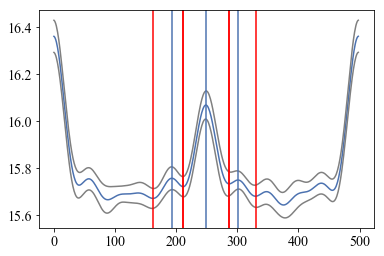

<Figure size 432x288 with 0 Axes>

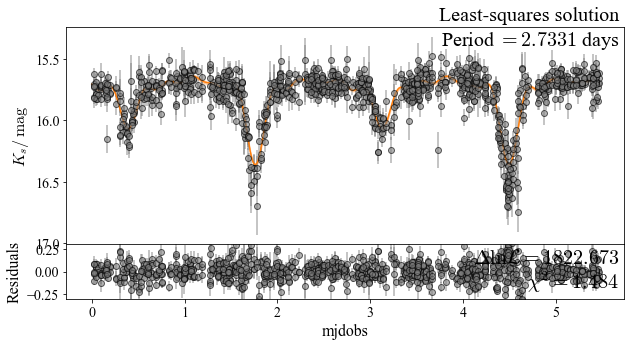

In [2494]:
find_period_check_minimum(5, det_range=[1000,3000],with_plot=True,show_data=True,show_plot=True, npoly=1)

[ 1.57828222e+01 -3.80134555e-02 -2.58447354e-02  1.59412944e-01
 -4.11928042e-02 -1.70613865e-02  3.74124434e-02 -5.05577198e-02
 -8.62097092e-02  3.10216901e-02 -5.94986565e-04 -5.68435059e-02
  5.28122305e-02  8.21048439e-03 -2.31716745e-02  4.44839432e-02
  3.70510548e-02 -2.91598464e-03  7.47005640e-03  1.16245613e-02
 -3.01308087e-02  1.29694841e-05  5.92637519e-09]


(2.7330523809539944,
 array([2.7329278]),
 True,
 array([0.04596709, 0.16464912, 0.04111912, 0.09994097]),
 0.69028354,
 0.5957445433676147,
 10)

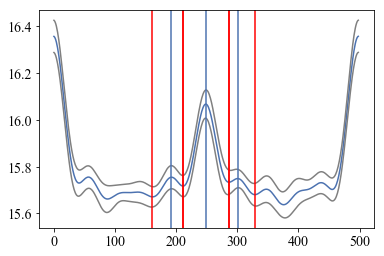

<Figure size 432x288 with 0 Axes>

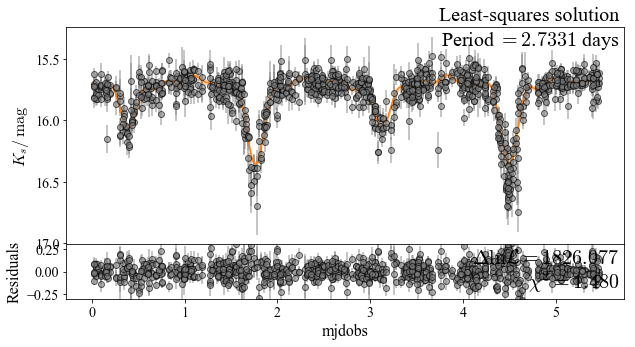

In [2502]:
find_period_check_minimum(5, det_range=[1000,3000],with_plot=True,show_data=True,show_plot=True, npoly=3)

In [2225]:
from functools import partial
pl = Pool(32)
pp = pl.map(partial(find_period_check_minimum, typee='EA/EB', noise_thresh=5, det_range=[1000,3000000]), np.arange(200))
pl.close()
pl.join()
out_period = np.array([pl[0] for pl in pp])
cat_period = np.array([pl[1][0] for pl in pp])
second_min = np.array([pl[2] for pl in pp])

In [2226]:
from functools import partial
pl = Pool(32)
pp_EW = pl.map(partial(find_period_check_minimum, typee='EW', noise_thresh=5, det_range=[1000,3000000]), np.arange(200))
pl.close()
pl.join()
out_period_EW = np.array([pl[0] for pl in pp_EW])
cat_period_EW = np.array([pl[1][0] for pl in pp_EW])
second_min_EW = np.array([pl[2] for pl in pp_EW])

[]

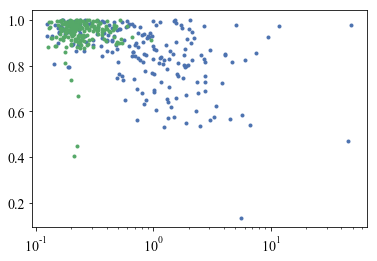

In [2227]:
plt.plot(out_period, np.array([pl[4] for pl in pp]),'.')
plt.semilogx()
plt.plot(out_period_EW, np.array([pl[4] for pl in pp_EW]),'.')
plt.semilogx()
# plt.ylim(0.5,1.)

(0.0, 0.3)

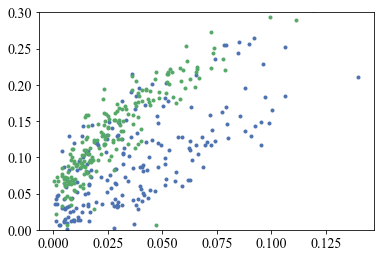

In [2228]:
plt.plot(np.array([pl[3][3] for pl in pp]), np.array([pl[3][1] for pl in pp]),'.')

plt.plot(np.array([pl[3][3] for pl in pp_EW]), np.array([pl[3][1] for pl in pp_EW]),'.')

# plt.plot(out_period_EW, np.array([pl[3][1]/pl[3][3]  for pl in pp_EW]),'.')
# plt.semilogx()
plt.ylim(0.,0.3)

In [2209]:
np.argwhere((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW)).flatten(),\
np.argwhere((np.abs((out_period_EW*2.-cat_period_EW)/cat_period_EW)<0.1)&(second_min_EW)).flatten()

(array([], dtype=int64), array([ 60, 112]))

[]

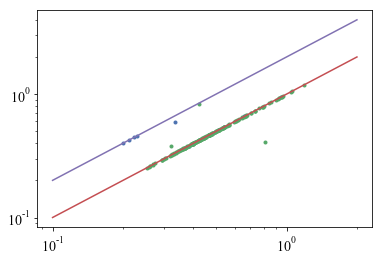

In [2216]:
plt.plot(out_period_EW[second_min_EW], cat_period_EW[second_min_EW], '.', label='Period good')
plt.plot(2.*out_period_EW[~second_min_EW], cat_period_EW[~second_min_EW], '.', label='Cat period is double')
xx = np.linspace(0.1,2.)
plt.plot(xx,xx)
plt.plot(xx,2.*xx)
plt.semilogy()
plt.semilogx()

[]

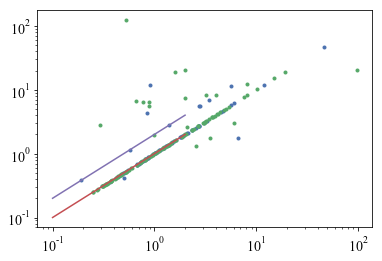

In [2229]:
plt.plot(out_period[second_min], cat_period[second_min], '.', label='Period good')
plt.plot(2.*out_period[~second_min], cat_period[~second_min], '.', label='Cat period is double')
xx = np.linspace(0.1,2.)
plt.plot(xx,xx)
plt.plot(xx,2.*xx)
plt.semilogy()
plt.semilogx()

In [2230]:
print(np.count_nonzero((((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)\
                    &(second_min_EW))|((np.abs((2.*out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW))))),\
print(np.count_nonzero((((np.abs((out_period-cat_period)/cat_period)<0.1)\
                    &(second_min))|((np.abs((2.*out_period-cat_period)/cat_period)<0.1)&(~second_min)))))

192
171


(None, None)

In [2349]:
print(np.count_nonzero((((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)\
                    &(second_min_EW))|((np.abs((2.*out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW))))),\
print(np.count_nonzero((((np.abs((out_period-cat_period)/cat_period)<0.1)\
                    &(second_min))|((np.abs((2.*out_period-cat_period)/cat_period)<0.1)&(~second_min)))))

192
13


(None, None)

In [2221]:
np.argwhere(~(((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)\
                    &(second_min_EW))|((np.abs((2.*out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW)))).flatten()

array([ 16, 118, 131, 133, 142, 165, 183, 194])

In [2222]:
np.argwhere(~(((np.abs((out_period-cat_period)/cat_period)<0.1)\
                &(second_min))|((np.abs((2.*out_period-cat_period)/cat_period)<0.1)&(~second_min)))).flatten()

array([ 11,  15,  16,  22,  25,  30,  32,  35,  38,  52,  63,  77,  78,
        84,  87,  88,  89,  91, 105, 114, 116, 130, 136, 146, 147, 150,
       165, 170, 183, 187, 189])

(1.3664701709586833,
 array([2.7329278]),
 False,
 array([0.03195797, 0.15330198, 0.0251503 , 0.08892007]),
 0.7990842,
 1.0)

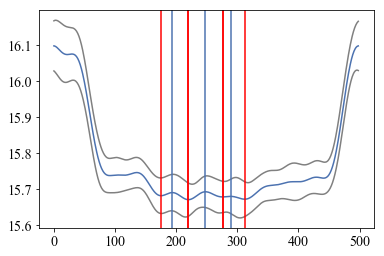

<Figure size 432x288 with 0 Axes>

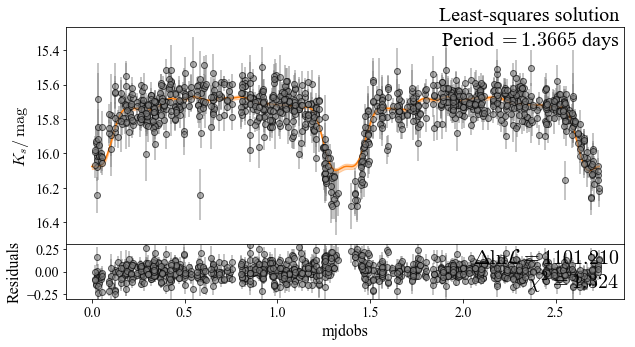

In [2348]:
find_period_check_minimum(5, typee='EA/EB', with_plot=True, show_data=True, show_plot=True, noise_thresh=5,
                         det_range=[1000,3000000],force_cat_period=False)

In [2098]:
np.count_nonzero((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)\
                    &(second_min_EW))+np.count_nonzero((np.abs((2.*out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW))

195

In [2099]:
np.count_nonzero((np.abs((out_period-cat_period)/cat_period)<0.1)\
                    &(second_min))+np.count_nonzero((np.abs((2.*out_period-cat_period)/cat_period)<0.1)&(~second_min))

174

[]

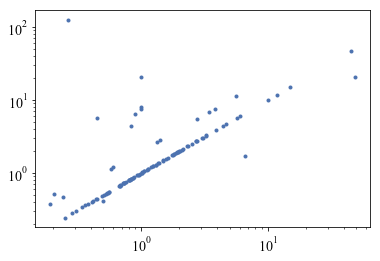

In [1001]:
plt.plot(out_period[second_min], cat_period[second_min], '.')
# plt.plot(2.*out_period[~second_min], cat_period[~second_min], '.')

plt.semilogy()
plt.semilogx()

In [977]:
np.argwhere((np.abs((out_period-cat_period)/cat_period)>0.1)&(second_min))

array([], shape=(0, 1), dtype=int64)

In [739]:
np.argwhere((np.abs((out_period-cat_period)/cat_period)<0.1)&(~second_min)).flatten(),\
np.argwhere((np.abs((out_period*2.-cat_period)/cat_period)<0.1)&(second_min)).flatten()

(array([91]), array([ 18,  35, 103, 123, 137, 150, 162, 183, 191]))

In [1064]:
lsc['lsq_chi_squared']

1469.8670117243869

(0.1300414191569809,
 array([0.2600828]),
 True,
 array([0.30209395, 0.11763596, 0.05230408, 0.02156872]),
 0.30769002,
 0.04074300546596808)

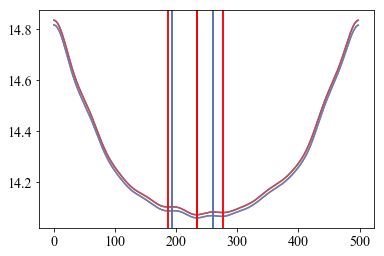

In [1063]:
find_period_check_minimum(34, False, False, typee='EW', phase_range=[0.35,0.65], show_plot=True)
# plt.figure()
# find_period_check_minimum(43, False, False, typee='EW', phase_range=[0.35,0.65], show_plot=True)

In [358]:
np.count_nonzero(second_min)

352

In [354]:
np.count_nonzero((np.abs((out_period-cat_period)/cat_period)<0.1)&(~second_min)),\
np.count_nonzero((np.abs((out_period*2.-cat_period)/cat_period)<0.1)&(second_min))

(3, 55)

In [450]:
import ellc

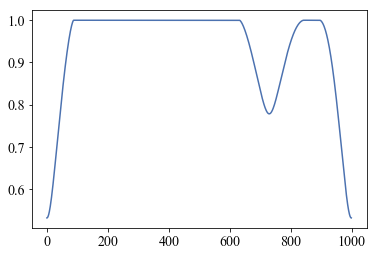

In [537]:
e = 0
plt.plot(ellc.lc(np.linspace(0.,1.,1000),0.3,0.3,0.5,80.,f_c=0.6,f_s=0.1))

(0.5371401900068609, array([0.53714839]), False)

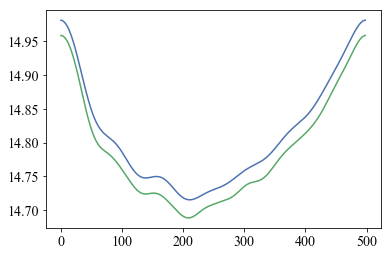

In [951]:
find_period_check_minimum(150, True, True, typee='RRab', phase_range=[0.35,0.65], show_plot=False)
plt.figure()
find_period_check_minimum(150, False, False, typee='RRab', phase_range=[0.35,0.65], show_plot=True)

(4.075634710529865, array([8.1523558]), False)

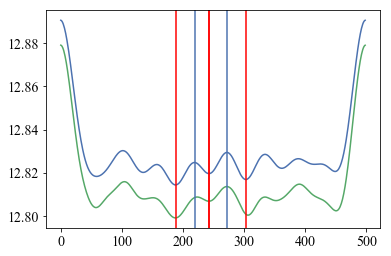

In [952]:
find_period_check_minimum(0, True, True, typee='EA/EB', phase_range=[0.35,0.65], show_plot=False)
plt.figure()
find_period_check_minimum(0, False, False, typee='EA/EB', phase_range=[0.35,0.65], show_plot=True)

In [396]:
XX = np.linspace(0.,10.,11)
n = (len(XX) - 1)
print((np.abs((np.subtract.outer(XX, np.array([3.])) + n//2)%(n) - n//2)).flatten())

[3. 2. 1. 0. 1. 2. 3. 4. 5. 4. 3.]


In [1874]:
def optimum_regularization(ss):
    
    p5_p95 = np.diff(np.nanpercentile(ss['mag'].values,[5.,95.]))[0]
    noise = np.nanmean(ss['error'].values)
    
    N = len(ss)
    
    return np.min([0.25, 2./(p5_p95/noise)**3/(N/100)])

In [2325]:
def optimum_smoothing(ss, plot=False):
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,10.,500000,
                                                     1,1,regularization=1e-5)
    
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,4,10,regularization=optimum_regularization(ss))
    if plot:
        plot_lc_LSQ(ss,lsc,fold=True)
#     plt.figure()
    reg_grid = np.logspace(-5,0,50)
    GCVS_r = np.zeros_like(reg_grid)
    for ii,rr in enumerate(reg_grid):
        lsc_t=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
        #                                                  1./cat_period[0],1./cat_period[0]*1.0001,
                                                         1./lsc['lsq_period'],1.00001/lsc['lsq_period'],
                                                         4,10,10,#lsc['lsq_nterms'],lsc['lsq_nterms'],
                                                         regularization=rr,
                                                         use_nfft=False,regularize_by_trace=True, regularization_power=2.,
                                                         keep_small=True,
                                                         check_multiples=False
                                                        )
        GCVS_r[ii]=GCVS(ss, lsc_t)
        
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,4,10,regularization=reg_grid[np.argmin(GCVS_r)])
    if plot:
        plot_lc_LSQ(ss,lsc,fold=True)
    mean = np.nanmean(ss['mag'].values/ss['error'].values**2)/ np.nanmean(1./ss['error'].values**2)
    std = np.sqrt(np.nanmean((ss['mag'].values-mean)**2/ss['error'].values**2)/ np.nanmean(1./ss['error'].values**2))
    return reg_grid[np.argmin(GCVS_r)], len(ss), \
            np.diff(np.nanpercentile(ss['mag'].values, [5.,95.]))[0],\
            np.nanmean(ss['error'].values), std,\
             optimum_regularization(ss)

In [1866]:
def use_opt_smooth(ii):
    
    sid,period,cat_period=v[['sourceid']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii],\
                v[['ls_period']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii],\
                v[['cat_period']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii]
    import sqlutilpy as sqlutil
    ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as arc,
                                    unnest(ambiguous_match) as amb,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
    ss = ss[(ss['mag']>0.)&(ss['arc']<13.)&(ss['amb']==0)].reset_index(drop=True)
    
    snr = np.diff(np.nanpercentile(ss['mag'].values,[5.,95.]))[0]/np.nanmean(ss['error'].values)

    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.01,10.,500000,
                                                     1,1,regularization=1e-5)
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,4,10,regularization=optimum_regularization(ss),
                                                     check_multiples=False)
    plot_lc_LSQ(ss, lsc, fold=True)

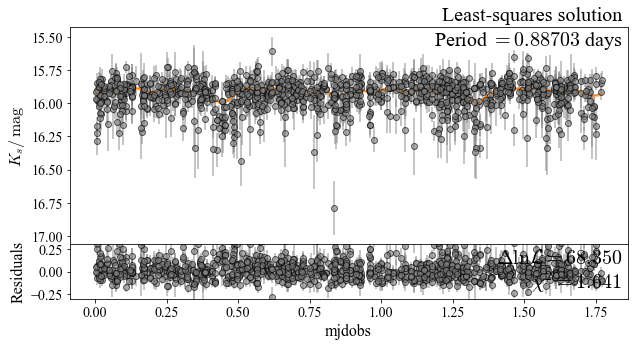

In [1990]:
use_opt_smooth(52)

In [2336]:
def find_opt_ii(ii, with_plot=False, n_det_cut=[0,10000000],typee='RRab'):
    fltr = (v['var_class']==typee)&(v['ks_n_detections']>n_det_cut[0])&(v['ks_n_detections']<n_det_cut[1])
    sid,period,cat_period=v[['sourceid']][fltr].values[ii],\
                v[['ls_period']][fltr].values[ii],\
                v[['cat_period']][fltr].values[ii]
    import sqlutilpy as sqlutil
    ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as arc,
                                    unnest(ambiguous_match) as amb,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
    ss = ss[(ss['mag']>0.)&(ss['arc']<13.)&(ss['amb']==0)].reset_index(drop=True)
    return optimum_smoothing(ss, plot=with_plot)

from multiprocessing import Pool

p = Pool(32)
opt_results = np.vstack([np.array([p.map(partial(find_opt_ii, n_det_cut=[0,100]), np.arange(200))])[0],
                         np.array([p.map(partial(find_opt_ii, n_det_cut=[100,1000]), np.arange(200))])[0],
                         np.array([p.map(partial(find_opt_ii, n_det_cut=[1000,3000]), np.arange(200))])[0]])
p.close()
p.join()

(0.004498432668969444,
 1003,
 0.2999992370605469,
 0.046520438,
 0.08989125,
 0.0007435325717672991)

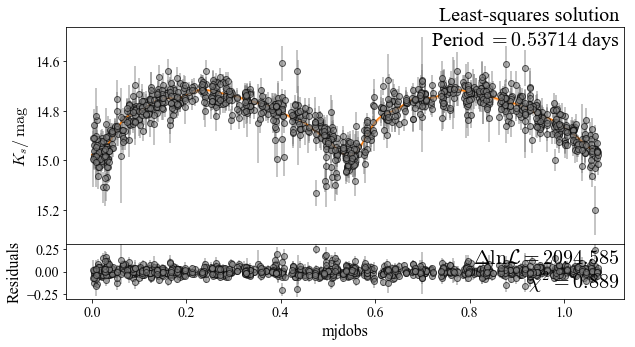

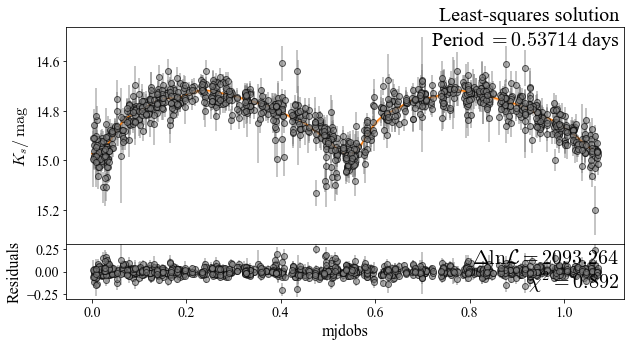

In [2340]:
find_opt_ii(0,typee='RRab', n_det_cut=[1000,100000], with_plot=True)

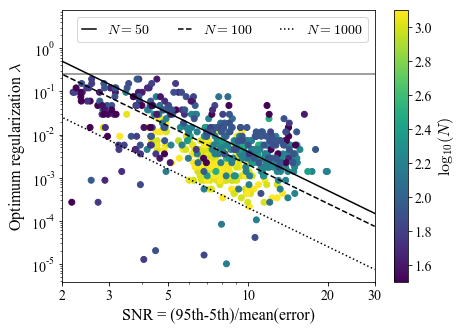

In [2338]:
from matplotlib.ticker import LogLocator, ScalarFormatter
plt.figure(figsize=[7.,5.])
plt.scatter(np.array(opt_results)[::-1,2]/np.array(opt_results)[::-1,3],
            np.array(opt_results)[::-1,0],c=np.log10(np.array(opt_results)[::-1,1]),vmax=3.1,vmin=1.5)
plt.axhline(0.25,color='gray')
xx = np.linspace(1.,30)
plt.plot(xx,2./xx**3/(50/100),color='k',label=r'$N=50$')
plt.plot(xx,2./xx**3,color='k',label=r'$N=100$',ls='dashed')
plt.plot(xx,2./xx**3/(1000/100),color='k',label=r'$N=1000$',ls='dotted')
plt.semilogy()
plt.semilogx()
plt.xlim(2,30)
plt.gca().xaxis.set_major_locator(LogLocator(subs=(0.5,1.,2.,3.)))
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('SNR = (95th-5th)/mean(error)')
plt.ylabel('Optimum regularization $\lambda$')
cax=plt.colorbar(label='$\log_{10}(N)$')
plt.legend(ncol=3,handlelength=1)
plt.savefig('optimal_regularization_10terms_rrlyrae.pdf', bbox_inches='tight')

In [1982]:
!pwd

/home/jls/work/data/gaiadr2/virac/variability/thomas/virac_classifier/test_notebooks


[]

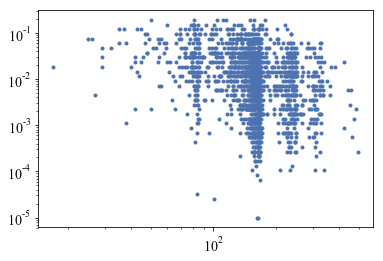

In [1632]:
plt.plot(np.array(opt_results)[:,1],np.array(opt_results)[:,0],'.')
plt.semilogy()
plt.semilogx()

Text(0, 0.5, 'Optimum regularization')

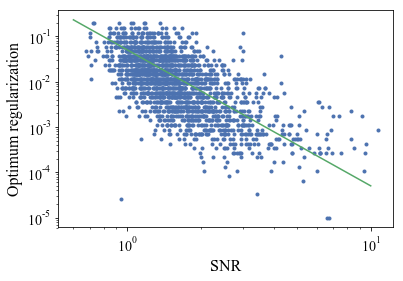

In [1630]:
plt.plot(np.array(opt_results)[:,3],np.array(opt_results)[:,0],'.')
xx = np.linspace(0.6,10.)
plt.plot(xx,.05/xx**3)
plt.semilogy()
plt.semilogx()
plt.xlabel('SNR')
plt.ylabel('Optimum regularization')
# plt.colorbar(label='log10(N)')

[]

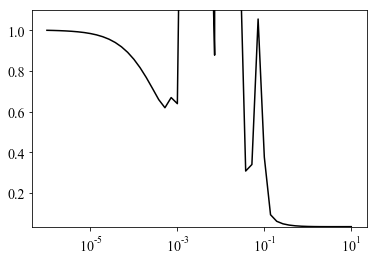

In [1378]:
arr=np.arange(len(ss))
np.random.shuffle(arr)
size = 20
times,mag,err=ss['mjdobs'].values[arr[:size]],ss['mag'].values[arr[:size]],ss['error'].values[arr[:size]]
tm_sort = np.argsort(times)
times, mag, err = times[tm_sort], mag[tm_sort], err[tm_sort]

lsc=fourier_poly_chi2_fit_full_nterms_iterations(times,mag,err,0.01,10.,500000,
                                                 1,1,regularization=1e-1)
lsc=fourier_poly_chi2_fit_full_nterms_iterations(times,mag,err,
#                                                  1./cat_period[0],1./cat_period[0]*1.0001,
                                                 0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                 2,4,10,regularization=1e-1,
                                                 use_nfft=False,regularize_by_trace=True, regularization_power=2.
#                                                  check_multiples=False
                                                )

reg_grid = np.logspace(-6,1,50)
GCVS_r = np.zeros_like(reg_grid)
for ii,rr in enumerate(reg_grid):
    lsc_t=fourier_poly_chi2_fit_full_nterms_iterations(times,mag,err,
    #                                                  1./cat_period[0],1./cat_period[0]*1.0001,
                                                     1./lsc['lsq_period'],1.00001/lsc['lsq_period'],
                                                     2,lsc['lsq_nterms'],lsc['lsq_nterms'],regularization=rr,
                                                     use_nfft=False,regularize_by_trace=True, regularization_power=2.,
                                                     keep_small=True
    #                                                  check_multiples=False
                                                    )
    GCVS_r[ii]=GCVS(ss, lsc_t)
plt.plot(reg_grid, GCVS_r/GCVS_r[0], 'k')
plt.ylim(np.min(GCVS_r/GCVS_r[0])*0.9,1.1)
# plt.semilogy()
plt.semilogx()

/data/jls/python3.5/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


[]

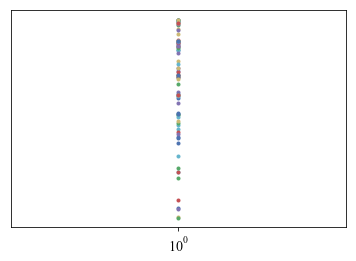

In [1279]:
X = get_X_matrix(ss['mjdobs'].values, lsc)
icov = np.diag(ss['error'].values**2)
plt.plot(icov,np.diag(get_H_matrix(ss, lsc)),'.')
plt.semilogy()
plt.semilogx()

In [1184]:
%%timeit -n 1 -r 1
np.linalg.inv(lsc['fourier_coeffs_cov'])

93.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


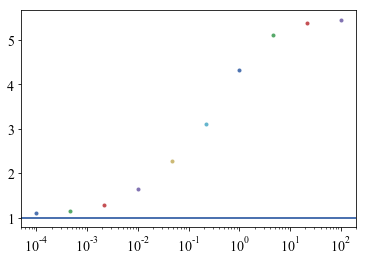

In [1266]:
for rr in np.logspace(-4,2,10):
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,10,10,regularization=rr,
                                                     use_nfft=False,regularize_by_trace=True, regularization_power=2.)
    plt.plot(rr,lsc['lsq_chi_squared']/len(ss),'.')
    plt.semilogx()
    plt.axhline(1.)

In [ ]:
chi2 = (y-Mx)**2/sigma**2 + lmbda**2 * M**2

[]

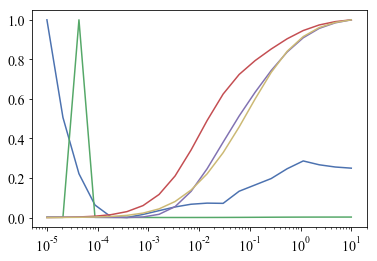

In [944]:
nfolds=5
test_period = lsc['lsq_period']
for test_size in [25,50,100,500,1000]:
    indxr = np.arange(len(ss))
    np.random.shuffle(indxr)
    
    indxr = indxr[:test_size]
    indx = np.arange(len(indxr))
    np.random.shuffle(indx)
    
    reg_grid = np.logspace(-5,1.,20)
    results_cv = np.zeros_like(reg_grid)
    for j,rr in enumerate(reg_grid):
        mm=0
        for ii in range(nfolds):
            indxt=indx[ii*len(indx)//nfolds:(ii+1)*len(indx)//nfolds]
            indxs=list(set(indx)-set(indxt))
            times,mag,err=ss['mjdobs'].values[indxr][indxs],ss['mag'].values[indxr][indxs],ss['error'].values[indxr][indxs]
            tsort = np.argsort(times)
            lsc_test=fourier_poly_chi2_fit_full_nterms_iterations(times[tsort],mag[tsort],err[tsort],
                                                             1./test_period, 1.001/test_period,
                                                             4,10,10,regularization=rr,
                                                             use_nfft=False,
                                                             check_multiples=False
                                                            )
            mm+=np.sum((retrieve_fourier_poly(ss['mjdobs'].values[indxr][indxt],lsc_test)-ss['mag'].values[indxr][indxt])/ss['error'].values[indxr][indxt])**2
        results_cv[j]=mm/nfolds
    plt.plot(reg_grid, (results_cv-np.min(results_cv))/(np.max(results_cv)-np.min(results_cv)))
plt.semilogx()

[0.41302154]
0.91351205
1.0


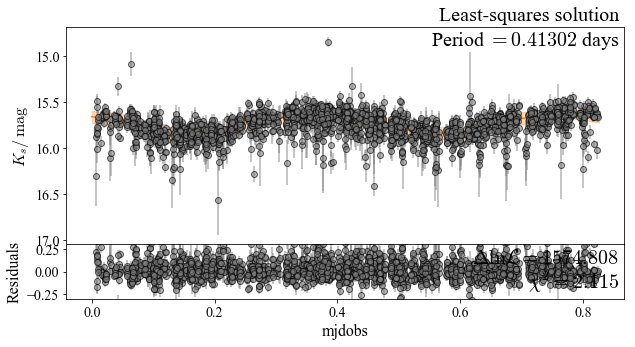

<Figure size 432x288 with 0 Axes>

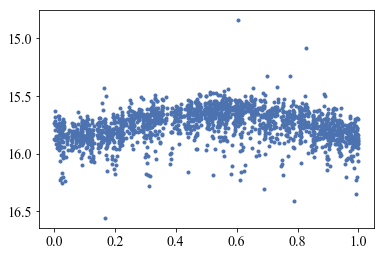

In [1484]:
ii=21
sid,period=v[['sourceid']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii],v[['ls_period']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii]
import sqlutilpy as sqlutil
ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
print(period)
import sys
sys.path.append('../../../../variability/')
from lc_utils import fourier_poly_chi2_fit_full_nterms_iterations, plot_lc_LSQ
lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,5.,50000,
                                                 4,4,regularization=1e-4)

plot_lc_LSQ(ss, lsc, fold=True);
t = time.time()
plt.figure()
print(find_peak_ratio(ss, lsc, bin_size=0.05))
print(find_peak_ratio_model(ss, lsc))

# print(lsc['lsq_period'])
# print(lsc['amplitudes'])
# lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
#                                .5/lsc['lsq_period'],.501/lsc['lsq_period'],2,
#                                3,regularization=1e-4,check_multiples=False)
# print(lsc['lsq_period'])
# print('nterms', lsc['lsq_nterms'])
# print(lsc['lsq_period'])
# print(lsc['amplitudes'])
# plot_lc_LSQ(ss, lsc, fold=True);
# print(find_peak_ratio(ss, lsc, bin_size=0.05))
# print(find_peak_ratio_model(ss, lsc))
# # ss2 = ss.copy()
# # ss2['mjdobs']+=lsc['phases'][0]*lsc['lsq_period']/(2.*np.pi)
# # lsc2=fourier_poly_chi2_fit_full_quick(ss2,nterms=4,minp=0.1,maxp=10.)
# # plot_lc_LSQ(ss2, lsc2, fold=True);
# # print(lsc['amplitudes'])
# # print(lsc2['fourier_coeffs'])

plt.figure()
from lc_utils import find_peak_ratio
plt.plot(((ss['mjdobs']-0.13514197587305296) / ( lsc['lsq_period'] ))% 1, 
         ss['mag'], '.')
plt.gca().invert_yaxis()

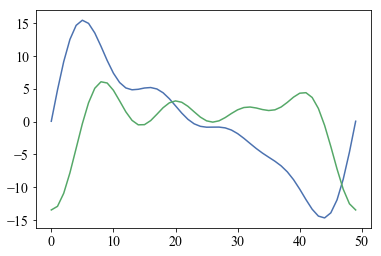

In [1470]:
from lc_utils import find_phase_of_minimum, retrieve_fourier_poly_firstderiv
min_phase = find_phase_of_minimum(ss,lsc)
plt.plot(retrieve_fourier_poly_firstderiv(np.ones(1)*(lsc['lsq_period'] * np.linspace(0.,1.) + min_phase), 
                                                                   lsc))

plt.plot(retrieve_fourier_poly_secondderiv(np.ones(1)*(lsc['lsq_period'] * np.linspace(0.,1.) + min_phase), 
                                                                   lsc)/100.)

In [ ]:
0.04644006 0.16473756 0.04156127 0.10164426

0.16230336 0.10178487 0.07449638 0.05780884

0.21794883 0.05455292 0.01340917 0.00190123
0.00295234 0.21795462 0.00276535 0.05215808

0.11610193 0.03603995 0.02605496 0.00870762
0.00220129 0.11569819 0.00416072 0.03255126

(-0.35, 0.35)

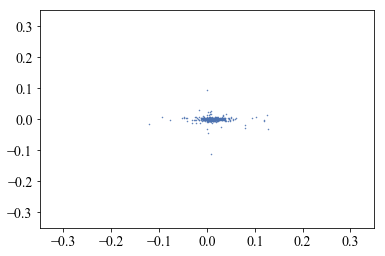

In [165]:

plt.plot((v['amp_1']*np.sin(v['phi_1'])/np.sin(2*v['phi_0']))[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],
         (v['amp_3']*np.sin(v['phi_3'])/np.sin(4*v['phi_0']))[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],'.',ms=1);
# plt.plot((v['amp_1'])[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],
#          (v['amp_3'])[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],'.',ms=1);
# plt.xlim(-5,5);plt.ylim(-5,5)
plt.xlim(-0.35,0.35)
plt.ylim(-0.35,0.35)

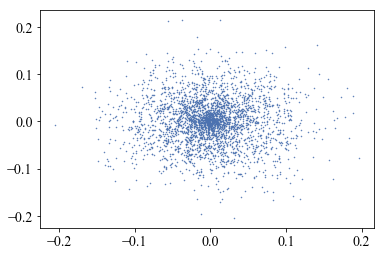

In [130]:

plt.plot((v['amp_0']*np.cos(v['phi_0']))[(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)],
         (v['amp_0']*np.sin(v['phi_0']))[(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)],'.',ms=1);
# plt.plot(v['lsq_period'][(v['var_class']=='EW')&(v['ks_n_detections']>100)],
#          1./v['a1_a3'][(v['var_class']=='EW')&(v['ks_n_detections']>100)],'.',ms=1);
# plt.semilogy()
# plt.semilogx()
# plt.xlim(0.05,10.)
# plt.ylim(0.,1.)

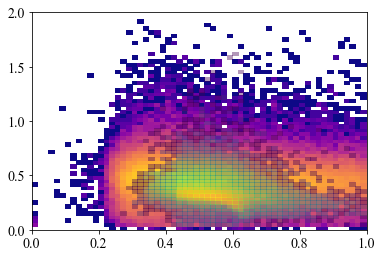

In [164]:
plt.hist2d(v['cat_period'][v['var_class']=='EA/EB'],
           v['ks_p95_p5'][v['var_class']=='EA/EB'],bins=60,range=[[0.,1.],[0.0,2.]],norm=LogNorm(),cmap=plt.cm.plasma);

plt.hist2d(v['cat_period'][v['var_class']=='RRab'],
           v['ks_p95_p5'][v['var_class']=='RRab'],bins=60,range=[[0.,1.],[0.0,2.]],norm=LogNorm(),alpha=0.4);


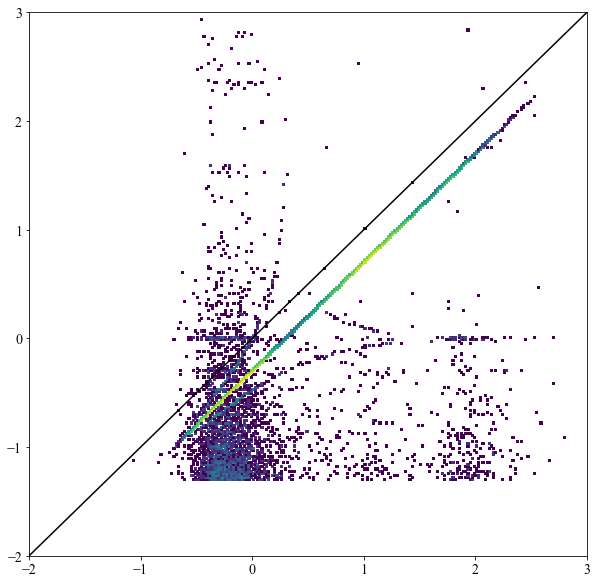

In [49]:

plt.figure(figsize=[10.,10.])
plt.hist2d(np.log10(v['cat_period'][v['var_class']=='Ell']),
           np.log10(v['ls_period'][v['var_class']=='Ell']),bins=260,range=[[-2.,3.],[-2.,3.]],norm=LogNorm());
xx = np.linspace(0.01,1000.)
plt.plot(np.log10(xx),np.log10(xx),color='k')

In [447]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total_test.pkl', 'rb') as f:
    v_test = pickle.load(f)
v_test = v_test[v_test['significant_second_minimum']==v_test['significant_second_minimum']].reset_index(drop=True)

In [965]:
v_test['lsq_period_scl'] = v_test['lsq_period'].copy()
v_test.loc[~v_test['significant_second_minimum']
                       &((v_test['var_class']=='EA/EB')|(v_test['var_class']=='EW')),'lsq_period_scl']*=2.

In [964]:
print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)
                       &v_test['significant_second_minimum']
                       &((v_test['var_class']=='EA/EB')|(v_test['var_class']=='EW'))))
print(np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)
                       &~v_test['significant_second_minimum']
                       &((v_test['var_class']=='EA/EB')|(v_test['var_class']=='EW'))))
print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)
                       &~((v_test['var_class']=='EA/EB')|(v_test['var_class']=='EW'))))
# print(np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum']))
# print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum']))
# print(np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum']))
# print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum'])
#       +np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum'])
#       +np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum'])
#       +np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum']))
print(len(v_test))

114
520
69
996


[]

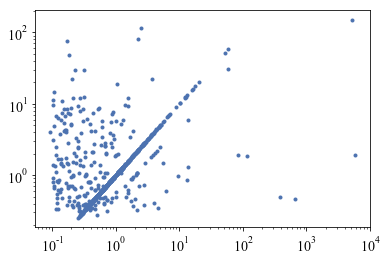

In [972]:
plt.plot(v_test['lsq_period_scl'][v_test['var_class']=='EA/EB'],v_test['cat_period'][v_test['var_class']=='EA/EB'],'.')
plt.semilogy()
plt.semilogx()

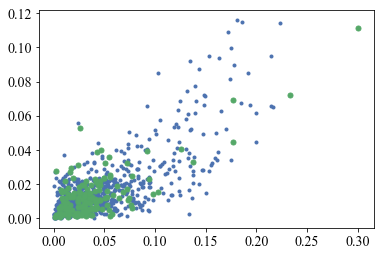

In [448]:
plt.plot(v_test['amp_1'][v_test['var_class']=='EA/EB'],
         v_test['amp_3'][v_test['var_class']=='EA/EB'], '.')
plt.plot(v_test['amp_1'][v_test['var_class']=='EW'],
         v_test['amp_3'][v_test['var_class']=='EW'], '.', ms=10)

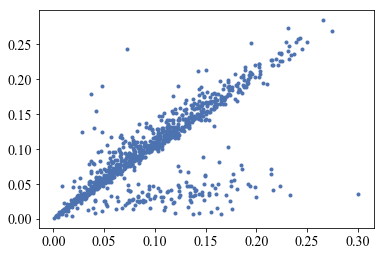

In [449]:
plt.plot(v_test['amp_double_1'],v_test['amp_0'],'.')

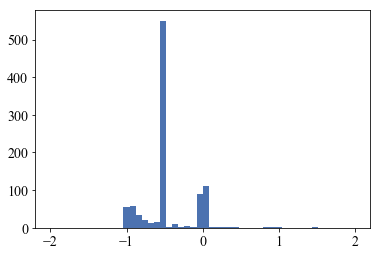

In [450]:
plt.hist((v_test['lsq_period']-v_test['cat_period'])/v_test['cat_period'],bins=50,range=[-2,2]);

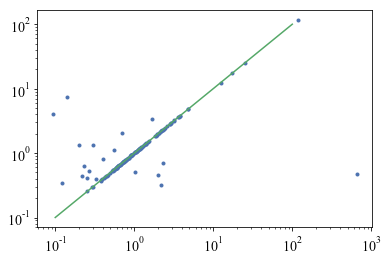

In [451]:
plt.plot(v_test['lsq_period'][v_test['significant_second_minimum']],
         v_test['cat_period'][v_test['significant_second_minimum']],'.')
plt.semilogy()
plt.semilogx()
xx = np.linspace(0.1,100.)
plt.plot(xx,xx)

In [456]:
print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum']))
print(np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum']))
print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum']))
print(np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum']))
print(np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum'])
      +np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum'])
      +np.count_nonzero((np.abs(v_test['lsq_period']/v_test['cat_period']-1)<0.05)&~v_test['significant_second_minimum'])
      +np.count_nonzero((np.abs(2.*v_test['lsq_period']/v_test['cat_period']-1)<0.05)&v_test['significant_second_minimum']))
print(len(v_test))

117
543
84
5
749
996


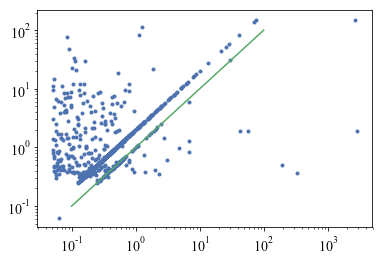

In [457]:
plt.plot(v_test['lsq_period'][~v_test['significant_second_minimum']],
         v_test['cat_period'][~v_test['significant_second_minimum']],'.')
plt.semilogy()
plt.semilogx()
xx = np.linspace(0.1,100.)
plt.plot(xx,xx)

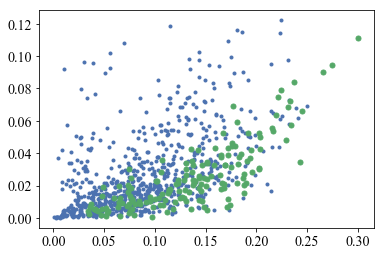

In [458]:
plt.plot(v_test['amp_double_1'][v_test['var_class']=='EA/EB'],
         v_test['amp_double_3'][v_test['var_class']=='EA/EB'], '.')
plt.plot(v_test['amp_double_1'][v_test['var_class']=='EW'],
         v_test['amp_double_3'][v_test['var_class']=='EW'], '.', ms=10)

[]

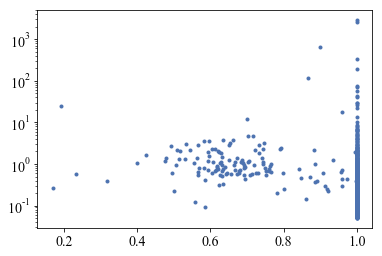

In [460]:
plt.plot(v_test['peak_ratio_model'], v_test['lsq_period'],'.')
plt.semilogy()